In [1]:
%load_ext autoreload
%autoreload 2

# AlexNet

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/models/2012_alexnet.ipynb)

[Alexnet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) was the first Deep Learning model to win the Imagenet competition in 2012 and it ignited the AI revolution we currently live in.

![alexnet](pics/alexnet.png)

In [2]:
import torch
import torch.nn as nn

class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        ) 
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        return self.head(self.backbone(x))

In [3]:
x = torch.randn(1, 3, 224, 224)
model = Alexnet()
model(x).shape

torch.Size([1, 1000])

These are the hyperparameters used in the original paper:

In [4]:
from convnets.datasets import ImageNet
import albumentations as A
from convnets.train import seed_everything
from torch.utils.data import DataLoader
from convnets.train import fit 
from convnets.metrics import error, top5_error

seed_everything()

trans = A.Compose([
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.RGBShift()
])

path = '/fastdata/imagenet256'
dataloaders  =  {
    'train': DataLoader(ImageNet(path, 'train', trans), batch_size=128, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(ImageNet(path, 'val', A.CenterCrop(224, 224)), batch_size=128, shuffle=False, num_workers=10, pin_memory=True),
}

model = Alexnet()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, verbose=True, threshold_mode='abs')
criterion = nn.CrossEntropyLoss()
metrics = {'t1err': error, 't5err': top5_error}

hist = fit(
    model, 
    dataloaders, 
    optimizer, 
    criterion,
    metrics, 
    max_epochs=3, # original paper says 90 epochs 
    # after_val=lambda val_logs: scheduler.step(val_logs['t1err'][-1]), # not working properly, lr decreases even if val error improves...
    limit_train_batches=100, # comment to train on full split
    limit_val_batches=100 # comment to validate on full split
)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resource

Number of trainable parameters: 62378344


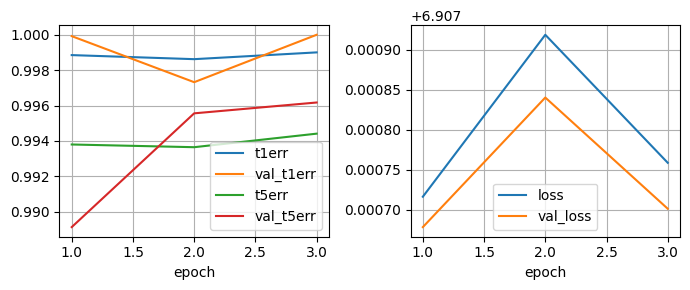

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['t1err', 'val_t1err', 't5err', 'val_t5err'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()


Originally, it took about five to six days on two NVIDIA GTX 580 3GB GPUs to train the model. Today, a single 3090 can do it in about 12 hours (with original hparams, can be further optimized with larger batch sizes, better optimizers and architecture elements such as Batch Norm and residual connections).

The reported metrics in the paper use tta (test time augmentation), averaging the predictions of 5 crops of the image plus their horizontal flips (a total of 10 predictions per image).

In [12]:
import torchvision

def tta(x):
    crops = torch.stack(torchvision.transforms.FiveCrop(224)(x))
    flips = torch.stack([torch.flip(crop, (-1,)) for crop in crops])
    return torch.cat([crops, flips]) 

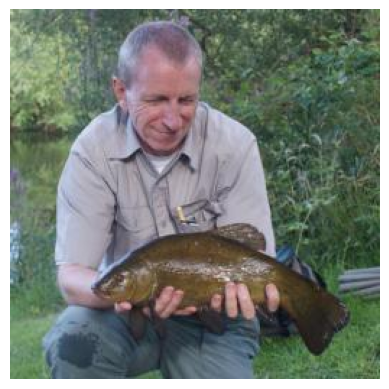

In [13]:
import matplotlib.pyplot as plt
from einops import rearrange

ds = ImageNet(path, 'val')
x, y = ds[10]
plt.imshow(rearrange(x, 'c h w -> h w c'))
plt.axis('off')
plt.show()

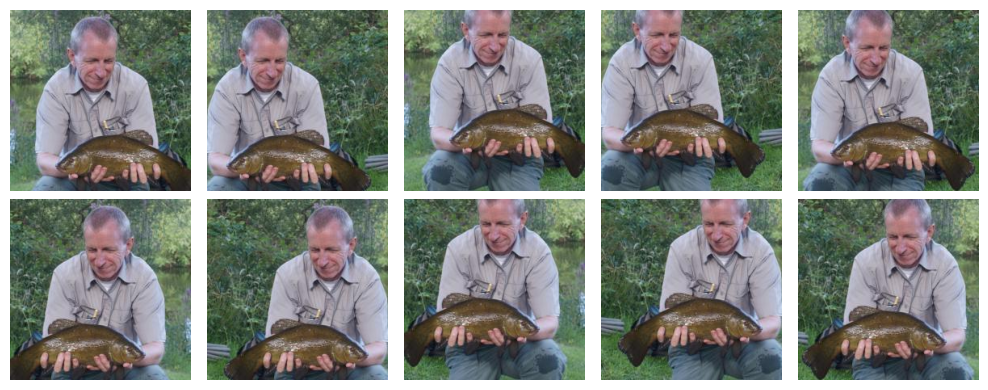

In [14]:
imgs = tta(torch.tensor([x]))

fig = plt.figure(figsize=(10, 4))
for i, img in enumerate(imgs):
	ax = plt.subplot(2, 5, i+1)
	ax.imshow(rearrange(img[0], 'c h w -> h w c'))
	ax.axis('off')
plt.tight_layout()
plt.show()

In [15]:
from tqdm import tqdm

model.cuda()
model.eval()
metrics = {'t1err': [], 't5err': []}
with torch.no_grad():
	for batch in tqdm(dataloaders['val']):
		x, y = batch
		x, y = x.cuda(), y.cuda()
		B, _, _, _ = x.shape
		x = tta(x)
		x = rearrange(x, 'n b c h w -> (n b) c h w')
		y_hat = model(x)
		y_hat = rearrange(y_hat, '(n b) c -> n b c', b=B)
		y_hat = y_hat.mean(dim=0)
		err = error(y_hat, y)
		metrics['t1err'].append(err.item())
		top5err = top5_error(y_hat, y)
		metrics['t5err'].append(top5err.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.53it/s]


In [16]:
import numpy as np

for k, v in metrics.items():
    print(f'{k}: {np.mean(v):.5f}')

t1err: 0.99902
t5err: 0.99480
